# Week 4: Dynamic Capacity Utilization Curves

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import pickle

import os
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib 
# import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.ticker import MultipleLocator

### load competition data and show some stats

In [3]:
df_comp_details = pd.read_csv('duopoly_competition_details.csv')
df_comp_details.fillna(0, inplace=True)

df_comp_details['revenue'] = df_comp_details['price'] * df_comp_details['demand']

df_comp_details.head(3)

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors,revenue
0,3C4dDe,1,1,LoutishMacaque,56.1,56.3,0,True,0.004,0.0,0.0
1,3C4dDe,1,2,LoutishMacaque,2.0,56.3,0,True,0.004,0.0,0.0
2,3C4dDe,1,3,LoutishMacaque,3.0,56.3,0,True,0.003,0.0,0.0


In [4]:
df_comp_details.groupby(['competitor_id','competition_id']).agg({
    'price' : 'mean',
    'price_competitor' : 'mean',
    'revenue' : 'sum'
}).round(1)

price  price_competitor  revenue
competitor_id    competition_id                                  
LoutishMacaque   3C4dDe            7.8              49.7  23390.7
                 3yUFj3           11.2              42.2  48087.9
OverjoyedRaccoon 46PBFJ           18.0              65.0  93026.1
                 aUynnu           18.0              69.4  92393.9

In [5]:
df_comp_details['unique_selling_season_key'] = df_comp_details.apply(lambda r:
                                "%s_%s" % (r.competition_id,r.selling_season), axis=1)

In [6]:
dfx_rev = df_comp_details.groupby('unique_selling_season_key').agg({
    'revenue' : 'sum'
}).reset_index()
dfx_rev.head(3)

,unique_selling_season_key,revenue
0,3C4dDe_1,115.9
1,3C4dDe_10,300.8
2,3C4dDe_100,337.3


array([[<Axes: title={'center': 'revenue'}>]], dtype=object)

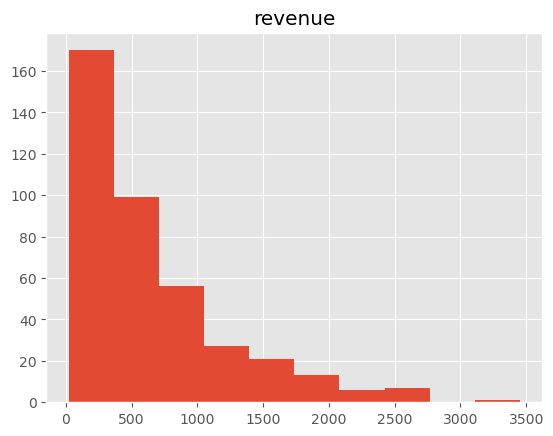

In [7]:
dfx_rev.hist()

## show the capacity utilization curve

In [8]:
dfp_util = pd.pivot_table(df_comp_details, 
                        values='demand', 
                        index=['selling_period'],
                        columns=['unique_selling_season_key'], 
                        aggfunc="mean")

# loop over columns to compute the % utilization
for c in dfp_util.columns:
    dfp_util[c] = dfp_util[c].cumsum()
    dfp_util[c] = round(dfp_util[c] / 80, 2)
    
dfp_util.tail()

unique_selling_season_key,3C4dDe_1,3C4dDe_10,3C4dDe_100,3C4dDe_11,3C4dDe_12,3C4dDe_13,3C4dDe_14,3C4dDe_15,3C4dDe_16,3C4dDe_17,...,aUynnu_90,aUynnu_91,aUynnu_92,aUynnu_93,aUynnu_94,aUynnu_95,aUynnu_96,aUynnu_97,aUynnu_98,aUynnu_99
selling_period,,,,,,,,,,,,,,,,,,,,,
96,0.64,0.82,0.80,0.74,0.84,0.84,0.79,0.80,0.75,0.86,...,1.0,0.71,0.68,0.66,0.86,0.94,0.75,0.91,0.89,0.62
97,0.66,0.84,0.80,0.74,0.88,0.85,0.81,0.81,0.79,0.89,...,1.0,0.72,0.70,0.69,0.86,0.95,0.75,0.92,0.90,0.62
98,0.70,0.84,0.81,0.74,0.92,0.85,0.81,0.81,0.81,0.89,...,1.0,0.75,0.72,0.70,0.88,0.98,0.78,0.96,0.91,0.62
99,0.71,0.85,0.84,0.74,0.92,0.85,0.84,0.82,0.81,0.89,...,1.0,0.75,0.74,0.71,0.88,0.99,0.78,0.98,0.94,0.65
100,0.75,0.88,0.85,0.75,0.92,0.89,0.84,0.86,0.82,0.90,...,1.0,0.76,0.75,0.72,0.88,1.00,0.78,0.99,0.99,0.66


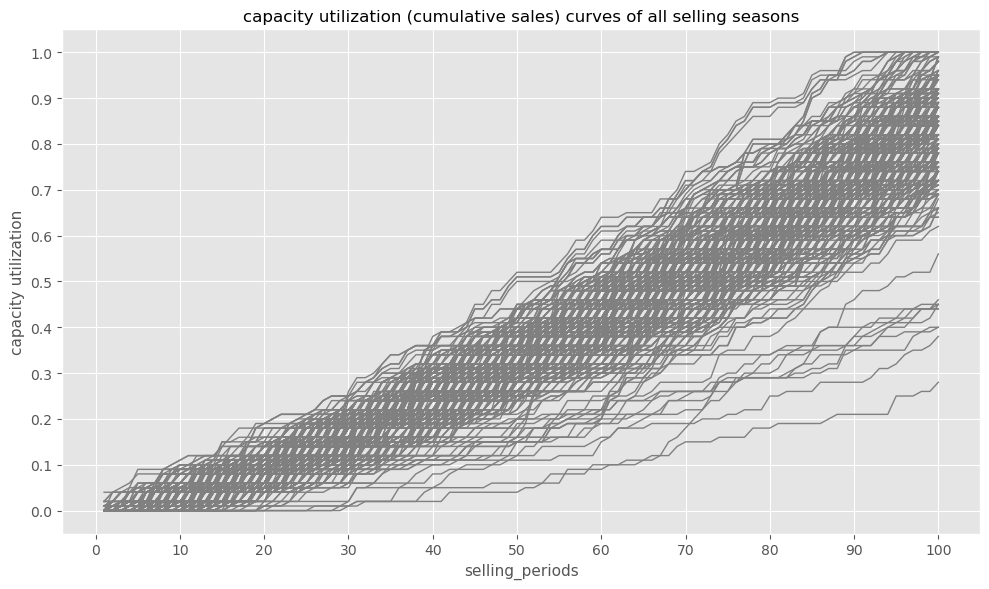

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(dfp_util.index, dfp_util, color='grey', 
        linestyle='-', linewidth=1, )
ax.set_xlabel('selling_periods', size=11)
# ax.set_xticks(np.arange(min(dft.index), max(dft.index)+1, 1.0))
ax.set_ylabel("capacity utilization" , size=11)

y_majorLocator = MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_majorLocator)
x_majorLocator = MultipleLocator(10)
ax.xaxis.set_major_locator(x_majorLocator)

ax.set_title("capacity utilization (cumulative sales) curves of all selling seasons", size=12)
# ax.legend(loc=0)

ax.grid(True)
fig.tight_layout()

plt.show()

# (1) build target capacity utilization curve based on top 20% revenue selling seasons

In [11]:
dfx_rev.revenue.quantile(0.8)

np.float64(1003.8199999999999)

In [12]:
top_selling_seasons = dfx_rev[dfx_rev.revenue>=dfx_rev.revenue.quantile(0.8)].unique_selling_season_key.unique()
top_selling_seasons[:10]

array(['3yUFj3_25', '3yUFj3_42', '3yUFj3_44', '3yUFj3_45', '3yUFj3_51',
       '3yUFj3_55', '3yUFj3_57', '3yUFj3_64', '3yUFj3_70', '3yUFj3_74'],
      dtype=object)

In [13]:
dfp_top_curves = dfp_util[top_selling_seasons]
dfp_top_curves.shape

(100, 80)

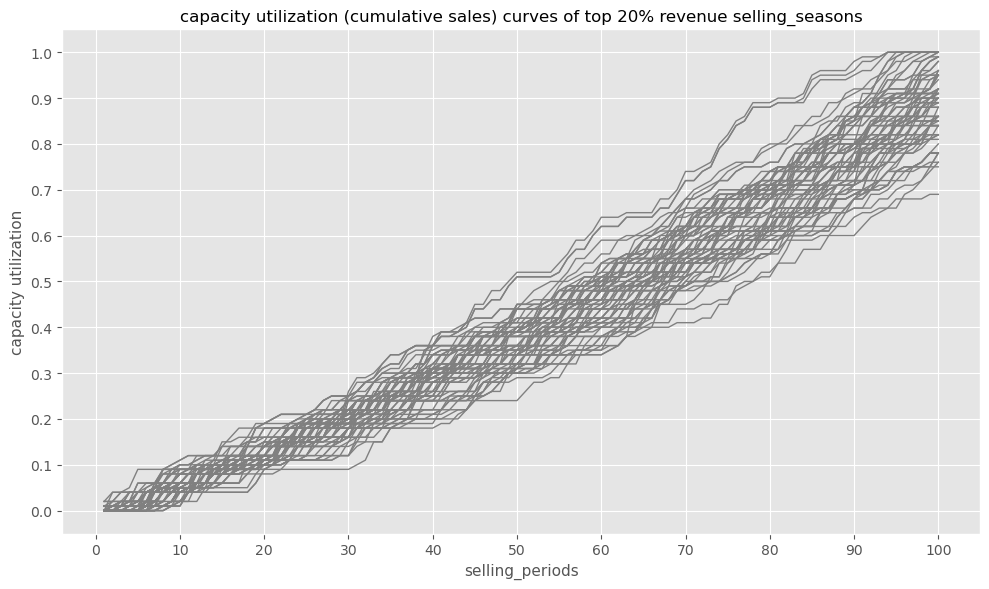

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(dfp_top_curves.index, dfp_top_curves, color='grey', 
        linestyle='-', linewidth=1, )
ax.set_xlabel('selling_periods', size=11)
# ax.set_xticks(np.arange(min(dft.index), max(dft.index)+1, 1.0))
ax.set_ylabel("capacity utilization" , size=11)

y_majorLocator = MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_majorLocator)
x_majorLocator = MultipleLocator(10)
ax.xaxis.set_major_locator(x_majorLocator)

ax.set_title("capacity utilization (cumulative sales) curves of top 20% revenue selling_seasons", size=12)
# ax.legend(loc=0)

ax.grid(True)
fig.tight_layout()

plt.show()

<Axes: xlabel='selling_period'>

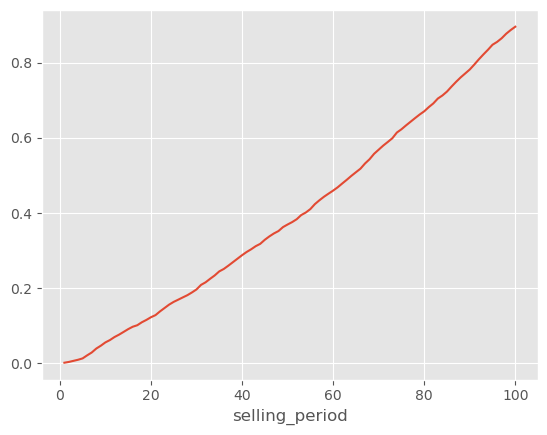

In [15]:
dfp_top_curves['mean_curve'] = dfp_top_curves.apply(lambda r: np.mean(r), axis=1)
dfp_top_curves['mean_curve'].plot()

In [16]:
target_sales_curve = {}
for t in np.arange(1,101,5):
    target = {}
    target['cap_util'] = round(dfp_top_curves.loc[t,'mean_curve'],2)
    target['sold_seats'] = round(dfp_top_curves.loc[t,'mean_curve'] * 80)
    target_sales_curve[str(t)] = target
    
target_sales_curve

{'1': {'cap_util': np.float64(0.0), 'sold_seats': 0},
 '6': {'cap_util': np.float64(0.02), 'sold_seats': 2},
 '11': {'cap_util': np.float64(0.06), 'sold_seats': 5},
 '16': {'cap_util': np.float64(0.1), 'sold_seats': 8},
 '21': {'cap_util': np.float64(0.13), 'sold_seats': 10},
 '26': {'cap_util': np.float64(0.17), 'sold_seats': 14},
 '31': {'cap_util': np.float64(0.21), 'sold_seats': 17},
 '36': {'cap_util': np.float64(0.25), 'sold_seats': 20},
 '41': {'cap_util': np.float64(0.3), 'sold_seats': 24},
 '46': {'cap_util': np.float64(0.34), 'sold_seats': 27},
 '51': {'cap_util': np.float64(0.38), 'sold_seats': 30},
 '56': {'cap_util': np.float64(0.42), 'sold_seats': 34},
 '61': {'cap_util': np.float64(0.47), 'sold_seats': 37},
 '66': {'cap_util': np.float64(0.52), 'sold_seats': 41},
 '71': {'cap_util': np.float64(0.58), 'sold_seats': 46},
 '76': {'cap_util': np.float64(0.63), 'sold_seats': 51},
 '81': {'cap_util': np.float64(0.68), 'sold_seats': 55},
 '86': {'cap_util': np.float64(0.74), 's

In [17]:
# save to pickle
with open('target_sales_curve.pkl', "wb") as f:
    pickle.dump(target_sales_curve, f, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# load from pickle
with open('target_sales_curve.pkl', 'rb') as f:
            target_curve = pickle.load(f)
target_curve

{'1': {'cap_util': np.float64(0.0), 'sold_seats': 0},
 '6': {'cap_util': np.float64(0.02), 'sold_seats': 2},
 '11': {'cap_util': np.float64(0.06), 'sold_seats': 5},
 '16': {'cap_util': np.float64(0.1), 'sold_seats': 8},
 '21': {'cap_util': np.float64(0.13), 'sold_seats': 10},
 '26': {'cap_util': np.float64(0.17), 'sold_seats': 14},
 '31': {'cap_util': np.float64(0.21), 'sold_seats': 17},
 '36': {'cap_util': np.float64(0.25), 'sold_seats': 20},
 '41': {'cap_util': np.float64(0.3), 'sold_seats': 24},
 '46': {'cap_util': np.float64(0.34), 'sold_seats': 27},
 '51': {'cap_util': np.float64(0.38), 'sold_seats': 30},
 '56': {'cap_util': np.float64(0.42), 'sold_seats': 34},
 '61': {'cap_util': np.float64(0.47), 'sold_seats': 37},
 '66': {'cap_util': np.float64(0.52), 'sold_seats': 41},
 '71': {'cap_util': np.float64(0.58), 'sold_seats': 46},
 '76': {'cap_util': np.float64(0.63), 'sold_seats': 51},
 '81': {'cap_util': np.float64(0.68), 'sold_seats': 55},
 '86': {'cap_util': np.float64(0.74), 's

# (2) Build randomized versions of the target capacity utilization curve

**idea:**

- estimate from the given curve the distribution of slope-steps
- draw random samples from this curve and use this to build new curves



In [20]:
df = pd.DataFrame(columns=['selling_period','perc_sales_target'])
for i in target_curve.keys():
    df.loc[len(df)] = [i, target_curve.get(i).get('cap_util') ]

df.head(10)

,selling_period,perc_sales_target
0,1,0.00
1,6,0.02
2,11,0.06
3,16,0.10
4,21,0.13
5,26,0.17
6,31,0.21
7,36,0.25
8,41,0.30
9,46,0.34


## (a) estimate the slope increases of the target curve as delta every 5 time periods

In [21]:
df['shifted_target'] = df['perc_sales_target'].shift(1)
df.head(3)

,selling_period,perc_sales_target,shifted_target
0,1,0.00,NaN
1,6,0.02,0.00
2,11,0.06,0.02


## (b) show the distribution (histogram) of the 5-step target increases

<Axes: >

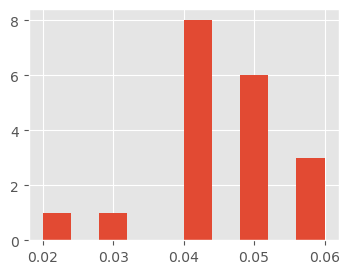

In [23]:
df['5day_delta'] =  df['perc_sales_target'] - df['shifted_target']

df['5day_delta'].hist(figsize=(4,3))

## (c) fit a normal distribution to these delta-values

In [24]:
delta_values = df['5day_delta'].dropna().values
delta_values

array([0.02, 0.04, 0.04, 0.03, 0.04, 0.04, 0.04, 0.05, 0.04, 0.04, 0.04,
       0.05, 0.05, 0.06, 0.05, 0.05, 0.06, 0.05, 0.06])

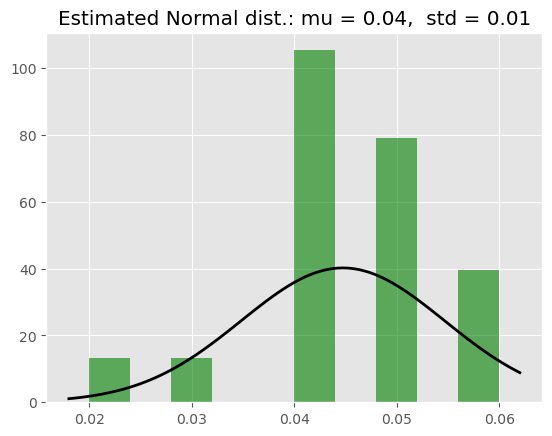

In [25]:
from scipy.stats import norm

# Fit a normal distribution to the data:
mu, std = norm.fit(delta_values)

# Plot the histogram.
plt.hist(delta_values, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Estimated Normal dist.: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

## (d) use distribution to fit new curves

In [32]:
norm.rvs(loc=mu, scale=std, size=20)

array([0.04280311, 0.04985475, 0.03477784, 0.05191661, 0.03948499,
       0.04561713, 0.04631234, 0.04467391, 0.05053642, 0.02041279,
       0.0373787 , 0.0607536 , 0.02694938, 0.03437362, 0.04484819,
       0.05270932, 0.03483705, 0.05387946, 0.05244278, 0.04798536])

<Axes: >

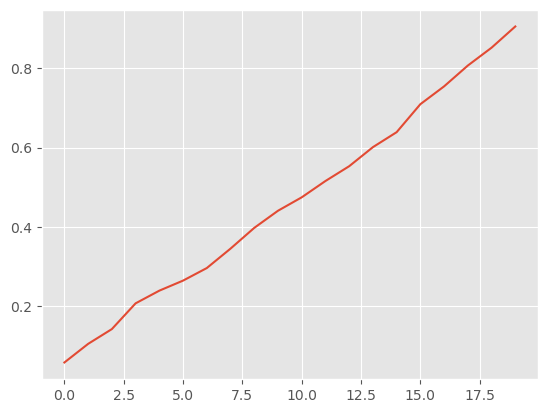

In [38]:
# generate random steps
df['sample_curve_1'] = norm.rvs(loc=mu, scale=std, size=20)
# aggregate the new random price curve
df['sample_curve_1'] = df['sample_curve_1'].cumsum()
# replace any value above 1 with 1, note that .where replaces the not holding False situations
df['sample_curve_1'] = df['sample_curve_1'].where(df['sample_curve_1'] < 1, 1.0)

df['sample_curve_1'].plot()

#### plot random curve vs. input target curve

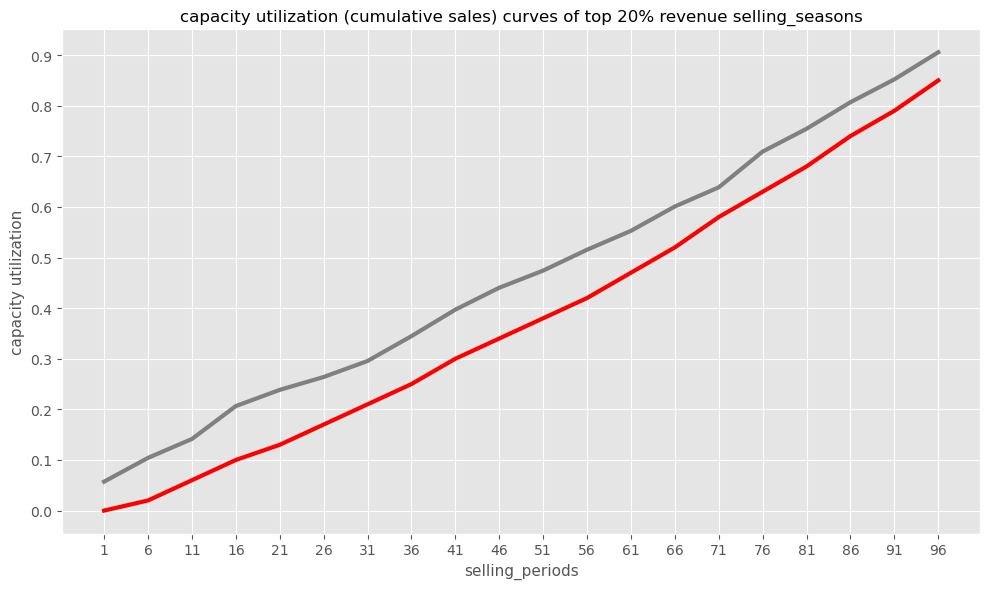

In [43]:
# plt.figure(figsize=(10, 6))
# plt.plot(df.index, df['sample_curve_1'], label='Random Curve')
# plt.plot(df.index, df['perc_sales_target'], label='Input Curve')
# plt.xlabel('Index')
# plt.ylabel('Values')
# plt.title('Two Curves Comparison')
# plt.legend()
# plt.grid(True)
# plt.show()
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df['selling_period'], df['perc_sales_target'], color='r', 
        linestyle='-', linewidth=3, label='org curve')

ax.plot(df['selling_period'], df['sample_curve_1'], color='grey', 
        linestyle='-', linewidth=3, label='random curve')

ax.set_xlabel('selling_periods', size=11)
# ax.set_xticks(np.arange(min(dft.index), max(dft.index)+1, 1.0))
ax.set_ylabel("capacity utilization" , size=11)

y_majorLocator = MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_majorLocator)

ax.set_title("capacity utilization (cumulative sales) curves of top 20% revenue selling_seasons", size=12)

ax.grid(True)
fig.tight_layout()

plt.show()